# Tier3 Classification Samples

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from xview2comp.nb_02c import *

### Generate classification samples from Tier 3 data set

In [4]:
SOURCE = Path('data/tier3/images/')

In [5]:
fnames = get_image_files(SOURCE)
npreimgs = pre_img_fpaths(fnames)
nposimgs = [pre2post_fpath(o) for o in npreimgs]
nposlabs = [img2label_fpath(o) for o in nposimgs]

In [6]:
path_polyimgs = Path('data/tier3/classification_images')
path_csv = Path('class_labels_tier3.csv')
os.makedirs(path_polyimgs, exist_ok=True)

Takes about 40 minutes to generate classification samples from Tier 3 data set.

In [6]:
generate_classification_train(nposimgs, nposlabs, path_polyimgs, path_csv)

In [7]:
df = pd.read_csv('class_labels_tier3.csv')

In [11]:
df.damage.value_counts()

no-damage        116209
minor-damage      10744
destroyed         10335
un-classified      8751
major-damage       7288
Name: damage, dtype: int64

### How many samples are there in each category (damage level)?

In [7]:
nsets = ['train', 'tier3']

In [8]:
csvnames = [f'class_labels_{o}.csv' for o in nsets]
annots = pd.concat([pd.read_csv(o) for o in csvnames], axis=0)

Looks like the uids under 'train' and 'tier3' do not overlap, so we can move all the images to the same directory, to keep things simple, if we want to.

In [9]:
annots.uid.unique().shape, annots.shape

((316114,), (316114, 2))

In [11]:
#export
def combine_nodamage_unclassified(annots):
    base_level = 'no-damage/un-classified'
    df = annots.copy()
    df.damage.replace('no-damage', base_level, inplace=True)
    df.damage.replace('un-classified', base_level, inplace=True)
    return df

In [12]:
annots = combine_nodamage_unclassified(annots)

It looks like the category 'no-damage/un-classified' has about ten times more samples than the other categories.

In [13]:
annots.damage.value_counts()

no-damage/un-classified    245379
minor-damage                25724
destroyed                   23562
major-damage                21449
Name: damage, dtype: int64

### Get all images' file name in a list

In [14]:
dirs = [Path('data')/o/'classification_images' for o in nsets]
fnames = [o_ for o in dirs for o_ in get_image_files(o)]

In [15]:
%%time
uids = [o.stem for o in fnames]

CPU times: user 24.4 ms, sys: 932 µs, total: 25.4 ms
Wall time: 24.9 ms


In [16]:
df_fnames = pd.DataFrame({'uid':uids, 'file':fnames})
df_fnames.head()

,uid,file
0,fb29655c-b56e-40f2-b843-538f1763b8d7,data/train/classification_images/fb29655c-b56e...
1,b3d43af0-22f1-41a6-acd9-0a369fec3e64,data/train/classification_images/b3d43af0-22f1...
2,61e4ff98-5017-4b88-bae5-c4948f6639b9,data/train/classification_images/61e4ff98-5017...
3,dfb071f1-0124-483d-b841-612e429f827b,data/train/classification_images/dfb071f1-0124...
4,80c817f8-288a-4547-938f-d2f36bcb9c48,data/train/classification_images/80c817f8-288a...


In [17]:
%%time
annots = pd.merge(annots, df_fnames, left_on='uid', right_on='uid', how='inner')

CPU times: user 118 ms, sys: 18 ms, total: 136 ms
Wall time: 136 ms


### Get area of image

In [18]:
#export
@property
def get_image_area(o):
    w, h = o.size
    return w * h

Image.area = get_image_area

In [19]:
%%time
annots['area'] = annots.file.apply(lambda o: open_image(o).area)

CPU times: user 40.3 s, sys: 10.4 s, total: 50.7 s
Wall time: 1min 9s


### Images' area distribution

Area is highly skewed.

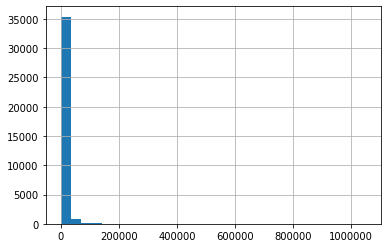

In [20]:
annots.area.hist(bins=30)

In [21]:
annots.area.describe()

count    3.659600e+04
mean     1.055318e+04
std      1.982204e+04
min      7.000000e+01
25%      2.914000e+03
50%      6.734000e+03
75%      1.284000e+04
max      1.048576e+06
Name: area, dtype: float64

#### Look at some of the largest images (by fractional area of the original image area)

In [22]:
sz_full = 1024**2

In [23]:
annots_frac1 = annots[annots.area > sz_full / 2**1]

In [24]:
annots_frac2 = annots[annots.area > sz_full / 2**2]

In [25]:
annots_frac3 = annots[annots.area > sz_full / 2**3]

In [26]:
annots_frac1.shape, annots_frac2.shape, annots_frac3.shape

((9, 4), (33, 4), (112, 4))

These do not look like a valid polygon image...  

* `annots_frac1`:  
* `annots_frac2`:  
* `annots_frac3`: 340

no-damage/un-classified


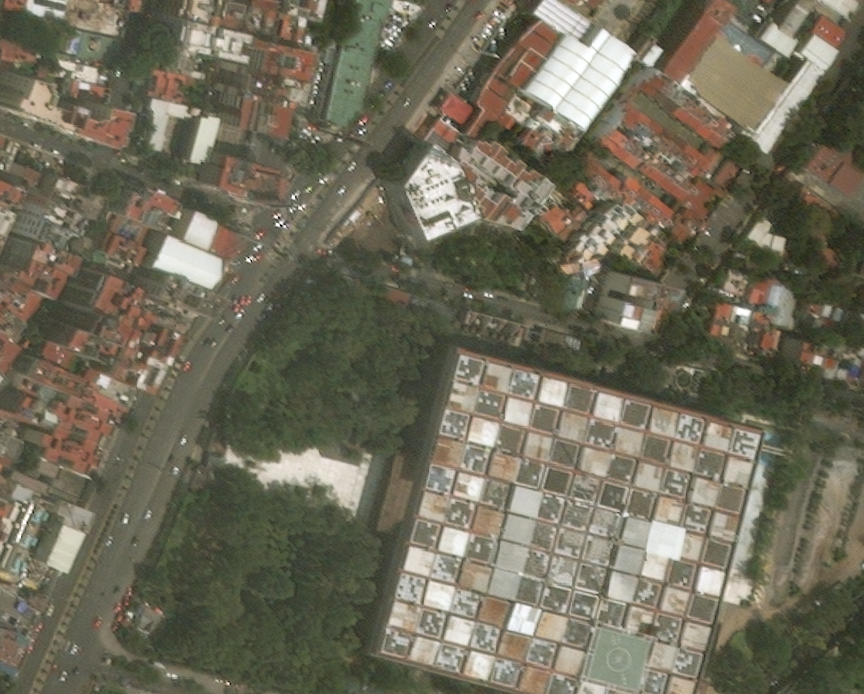

In [27]:
idx = 2
print(annots_frac1.iloc[idx].damage)
open_image(annots_frac1.iloc[idx].file)

### Get a balanced training set

There are many more 'no-damage/un-classified' images than others.

In [28]:
annots.damage.value_counts()

no-damage/un-classified    26451
major-damage                3645
minor-damage                3524
destroyed                   2976
Name: damage, dtype: int64

In [29]:
_damg_levels = ['minor-damage', 'major-damage', 'destroyed']

Reduce the `no-damage/un-classified` category to about the same size as the other categories.  Then, re-join it to the rest.

In [30]:
nkeep = int(annots.damage.value_counts().loc[_damg_levels].mean())
annots_undamg_subset = annots[annots.damage == 'no-damage/un-classified'].sample(nkeep)
annots_damg = annots[annots.damage.isin(_damg_levels)]

In [31]:
annots_trn = pd.concat([annots_damg, annots_undamg_subset], axis=0)

In [32]:
annots_trn.damage.value_counts()

major-damage               3645
minor-damage               3524
no-damage/un-classified    3381
destroyed                  2976
Name: damage, dtype: int64

Notice that the reduced set's quantiles agree quite well with the original set's.  

In [33]:
annots_trn.area.describe()

count     13526.000000
mean      10394.565208
std       17300.672584
min          70.000000
25%        2925.000000
50%        6887.000000
75%       13104.000000
max      612352.000000
Name: area, dtype: float64

In [34]:
annots.area.describe()

count    3.659600e+04
mean     1.055318e+04
std      1.982204e+04
min      7.000000e+01
25%      2.914000e+03
50%      6.734000e+03
75%      1.284000e+04
max      1.048576e+06
Name: area, dtype: float64

However, we can also add in those very large images that are left out.

In [35]:
annots_xla = annots[annots.area > annots_trn.area.max()]

In [36]:
annots_trn = annots_trn.append(annots_xla)

Now it looks like we have a good range of image sizes, and balanced damage categories.

In [37]:
annots_trn.area.describe()

count    1.353000e+04
mean     1.063012e+04
std      2.221806e+04
min      7.000000e+01
25%      2.925250e+03
50%      6.889000e+03
75%      1.310400e+04
max      1.048576e+06
Name: area, dtype: float64

In [38]:
annots_trn.damage.value_counts()

major-damage               3645
minor-damage               3524
no-damage/un-classified    3385
destroyed                  2976
Name: damage, dtype: int64

In [42]:
annots_trn.to_csv('class_labels_combined_cpu.csv', index=False)

In [41]:
annots_trn.head()

,damage,uid,file,area
93,minor-damage,c112f7b8-bc78-41c2-bbaf-76045c5a63ec,data/train/classification_images/c112f7b8-bc78...,42432
94,minor-damage,700efd81-2bf7-4702-b89a-760cc723b1fa,data/train/classification_images/700efd81-2bf7...,16488
95,minor-damage,613366fe-87b5-4653-87fe-cd1b4f3ffc6c,data/train/classification_images/613366fe-87b5...,31768
96,minor-damage,238f8100-b63d-4ee3-aa17-c3fcf1be21a0,data/train/classification_images/238f8100-b63d...,50193
97,minor-damage,6ef1c766-248f-4c69-93e6-23218b5210eb,data/train/classification_images/6ef1c766-248f...,22800


# -fin